In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import torchvision
import tqdm
import matplotlib.pyplot as plt
import torch.distributions as dist
import abc

from torch.utils.data import DataLoader
from torch.distributions.distribution import Distribution
import torchvision.transforms as tr

from priors import *
from models import *
from data import *

torch.manual_seed(42)

c:\Users\jorge\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# only run this cell if you use weights and biases for logging
import wandb

wandb.init(project = "BNN_VI", 
            config = {"learning_rate": 0.001,
                      "batch_size": 128,
                      "epochs": 10,
                      "hidden_size": 100,
                      "Temperature": 0.1,})


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jorgefernando17. Use `wandb login --relogin` to force relogin


In [3]:
# Load MNIST dataset with specified transforms
# always use ToTensor() as first transform
# possible transforms: RandomRotation, RandomCrop, GaussianBlur
# avoid Normalize (already done), RandomHorizontalFlip (for MNIST), RandomVerticalFlip (for MNIST)
transform = tr.Compose([tr.ToTensor()])
augmentations = tr.Compose([tr.RandomRotation(15)])

dataset = Data("MNIST", augmentations = None)
train_data, test_data = dataset.get_data()

# Print some information about the dataset
print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

# Create data loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


Train data size:  60000
Test data size:  10000


tensor(5)


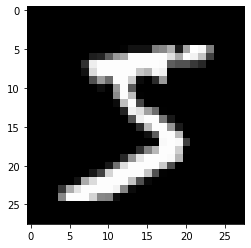

In [4]:
# display some images
image_index = 0
feature = dataset.trainset[image_index][0]
# feature = dataset.trainset_extra[image_index][0] # to display images from the augmented dataset
label = train_data[0][1]
print(label)
plt.imshow(feature.squeeze(), cmap='gray')
plt.show()


In [12]:
# set the Temperature
Temperature_posterior = 1

# create the Bayesian Neural Network
model = Bayesian_Neural_Network(input_dim = 28*28, output_dim = 10, hidden_dims = [100], Temperature = Temperature_posterior)
print(model)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)

# train the model
epochs = 10
num_samples = 5

for epoch in tqdm.tqdm(range(epochs)):
    num_batches = len(train_loader)
    for i, (x, y) in enumerate(train_loader):
        # zero the gradients
        optimizer.zero_grad()

        # reshape the data
        x = x.view(-1, 28*28)

        # reset loss
        loss = torch.tensor(0.0)

        # forward pass
        for e in range(num_samples):
            output, kl_divergence = model(x)
            loss += (F.nll_loss(F.softmax(output, dim = 1), y, reduction = "sum") + kl_divergence/num_batches)/num_samples

        # backward pass
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # accuracy
        acc = (output.argmax(dim = 1) == y).float().mean()


        # print the loss
        if i % 100 == 0:
            print(f"Epoch: {epoch} | Batch: {i} | Loss: {loss.item()}, accuracy: {acc.item()}")
            scheduler.step()
            wandb.log({"loss": loss.item(), "accuracy": acc.item(), "epoch": epoch, "batch": i})
            wandb.log({"learning_rate": scheduler.get_lr()[0]})
           
        

  0%|          | 0/10 [00:00<?, ?it/s]

Bayesian_Neural_Network(
  (layers): ModuleList(
    (0): Linear_Layer(
      (weight_prior): MultivariateDiagonalGaussian()
      (bias_prior): MultivariateDiagonalGaussian()
      (weight_posterior): MultivariateDiagonalGaussian()
      (bias_posterior): MultivariateDiagonalGaussian()
    )
    (1): Linear_Layer(
      (weight_prior): MultivariateDiagonalGaussian()
      (bias_prior): MultivariateDiagonalGaussian()
      (weight_posterior): MultivariateDiagonalGaussian()
      (bias_posterior): MultivariateDiagonalGaussian()
    )
  )
  (activation): ReLU(inplace=True)
)
Epoch: 0 | Batch: 0 | Loss: -14.177267074584961, accuracy: 0.1171875
Epoch: 0 | Batch: 100 | Loss: -13.863455772399902, accuracy: 0.0625
Epoch: 0 | Batch: 200 | Loss: -10.15003776550293, accuracy: 0.0546875
Epoch: 0 | Batch: 300 | Loss: -13.07967758178711, accuracy: 0.1328125
Epoch: 0 | Batch: 400 | Loss: -13.951836585998535, accuracy: 0.1328125


 10%|█         | 1/10 [00:22<03:19, 22.16s/it]

Epoch: 1 | Batch: 0 | Loss: -15.54577922821045, accuracy: 0.0859375
Epoch: 1 | Batch: 100 | Loss: -18.85175323486328, accuracy: 0.15625
Epoch: 1 | Batch: 200 | Loss: -19.63405990600586, accuracy: 0.171875
Epoch: 1 | Batch: 300 | Loss: -17.097949981689453, accuracy: 0.1328125
Epoch: 1 | Batch: 400 | Loss: -28.040882110595703, accuracy: 0.2421875


 20%|██        | 2/10 [00:43<02:55, 21.94s/it]

Epoch: 2 | Batch: 0 | Loss: -33.388511657714844, accuracy: 0.2265625
Epoch: 2 | Batch: 100 | Loss: -26.959318161010742, accuracy: 0.25
Epoch: 2 | Batch: 200 | Loss: -38.84915542602539, accuracy: 0.3125


 20%|██        | 2/10 [00:54<03:39, 27.42s/it]


KeyboardInterrupt: 

In [ ]:
# predict class probabilities for the test data
x_test = test_data[:][0].clone().detach()
y_test = test_data[:][1].clone().detach()

predicted_probs = model.predict_probs(x_test, 100)
top_probs = torch.max(predicted_probs, axis = 1)
predicted_class = torch.argmax(predicted_probs, axis = 1)

accuracy = torch.sum(predicted_class == y_test) / len(y_test)
print(f"Accuracy: {accuracy}")

print(torch.hstack((torch.tensor(predicted_class).unsqueeze(1), torch.tensor(y_test).unsqueeze(1))))

In [ ]:
def ece(predicted_probabilities: np.ndarray, labels: np.ndarray, n_bins: int = 30) -> float:
    """
    Computes the Expected Calibration Error (ECE).
    Many options are possible; in this implementation, we provide a simple version.
    Using a uniform binning scheme on the full range of probabilities, zero
    to one, we bin the probabilities of the predicted label only (ignoring
    all other probabilities). For the ith bin, we compute the avg predicted
    probability, p_i, and the bin's total accuracy, a_i.
    We then compute the ith calibration error of the bin, |p_i - a_i|.
    The final returned value is the weighted average of calibration errors of each bin.
    :param predicted_probabilities: Predicted probabilities, float array of shape (num_samples, num_classes)
    :param labels: True labels, int tensor of shape (num_samples,) with each entry in {0, ..., num_classes - 1}
    :param n_bins: Number of bins for histogram binning
    :return: ECE score as a float
    """
    num_samples, num_classes = predicted_probabilities.shape

    # Predictions are the classes with highest probability
    predictions = np.argmax(predicted_probabilities, axis=1)
    prediction_confidences = predicted_probabilities[range(num_samples), predictions]

    # Use uniform bins on the range of probabilities, i.e. closed interval [0.,1.]
    bin_upper_edges = np.histogram_bin_edges([], bins=n_bins, range=(0., 1.))
    bin_upper_edges = bin_upper_edges[1:]  # bin_upper_edges[0] = 0.

    probs_as_bin_num = np.digitize(prediction_confidences, bin_upper_edges)
    sums_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins, weights=prediction_confidences)
    sums_per_bin = sums_per_bin.astype(np.float32)

    total_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins) \
        + np.finfo(sums_per_bin.dtype).eps  # division by zero
    avg_prob_per_bin = sums_per_bin / total_per_bin

    onehot_labels = np.eye(num_classes)[labels]
    accuracies = onehot_labels[range(num_samples), predictions]  # accuracies[i] is 0 or 1
    accuracies_per_bin = np.bincount(probs_as_bin_num, weights=accuracies, minlength=n_bins) / total_per_bin

    prob_of_being_in_a_bin = total_per_bin / float(num_samples)

    ece_ret = np.abs(accuracies_per_bin - avg_prob_per_bin) * prob_of_being_in_a_bin
    ece_ret = np.sum(ece_ret)
    return float(ece_ret)

In [ ]:
ece(predicted_probs, y_test, n_bins = 30)

In [ ]:
import torchmetrics
from torchmetrics.functional import calibration_error

calibration_error(predicted_probs, y_test, n_bins = 30, task = "multiclass", norm="l1", num_classes=10)

In [ ]:
wandb.finish()